<a href="https://colab.research.google.com/github/iranfromiran/computer-vision-brain-tumor/blob/cleanCode/ai_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchmetrics import Precision, Recall, F1Score
from sklearn.metrics import classification_report

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


import and preprocess the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Colab Notebooks/experiment data'
print("Training files:", os.listdir(os.path.join(data_dir, 'training')))
print("Testing files:", os.listdir(os.path.join(data_dir, 'testing')))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/training'
test_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Mounted at /content/drive
Training files: ['glioma', 'pituitary', 'notumor', 'meningioma']
Testing files: ['glioma', 'notumor', 'meningioma', 'pituitary']


Sample image shape (after transform): torch.Size([1, 224, 224])
Label: 0


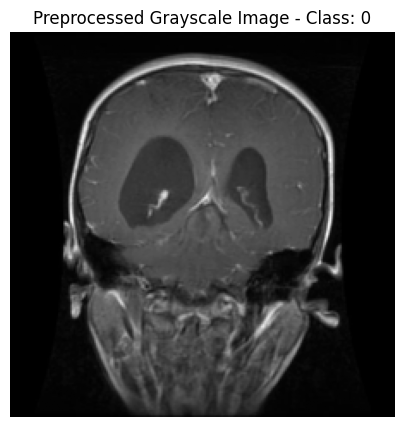

In [ ]:
# Verify preprocessing
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    return tensor

sample_image, sample_label = train_dataset[0]
print("Sample image shape (after transform):", sample_image.shape)  # Should be [1, 224, 224]
print("Label:", sample_label)


denorm_image = denormalize(sample_image.clone(), mean=[0.485], std=[0.229])
denorm_image = denorm_image.squeeze(0).numpy()
plt.figure(figsize=(5, 5))
plt.imshow(denorm_image, cmap='gray')
plt.title(f"Preprocessed Grayscale Image - Class: {sample_label}")
plt.axis('off')
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):  # 4 classes: glioma, meningioma, notumor, pituitary
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # 1 channel input for grayscale
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Size after pooling (224/4 = 56)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x
model = SimpleCNN(num_classes=4).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

print('Training Finished!')

Epoch [1/5], Step [10/27], Loss: 1.3635
Epoch [1/5], Step [20/27], Loss: 1.2786
Epoch [2/5], Step [10/27], Loss: 1.0691
Epoch [2/5], Step [20/27], Loss: 1.0065
Epoch [3/5], Step [10/27], Loss: 0.8144
Epoch [3/5], Step [20/27], Loss: 0.7984
Epoch [4/5], Step [10/27], Loss: 0.6227
Epoch [4/5], Step [20/27], Loss: 0.6731
Epoch [5/5], Step [10/27], Loss: 0.5506
Epoch [5/5], Step [20/27], Loss: 0.4774
Training Finished!


In [ ]:
# Evaluataion
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)

all_preds_tensor = torch.tensor(all_preds).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

prec_score = precision(all_preds_tensor, all_labels_tensor)
rec_score = recall(all_preds_tensor, all_labels_tensor)
f1_score = f1(all_preds_tensor, all_labels_tensor)

print(f'Precision (macro): {prec_score:.4f}')
print(f'Recall (macro): {rec_score:.4f}')
print(f'F1-score (macro): {f1_score:.4f}')


class_names = train_dataset.classes
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Accuracy on test set: 65.31%
Precision (macro): 0.6497
Recall (macro): 0.6499
F1-score (macro): 0.6445

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.56      0.45      0.50        22
  meningioma       0.43      0.52      0.47        23
     notumor       0.80      0.67      0.73        30
   pituitary       0.81      0.96      0.88        23

    accuracy                           0.65        98
   macro avg       0.65      0.65      0.64        98
weighted avg       0.66      0.65      0.65        98

